In [1]:
# In this code used ResNet50 as pretrained model to build image classifier to detect 6 places from
#historical places in Jordan 

###########Import Required libraries#####################
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Flatten, Dropout, BatchNormalization
from keras.models import Sequential, save_model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras import optimizers
from keras.callbacks import EarlyStopping

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
##################Preprocessing data using Data Augmentation#################
def prepare_data(train_dir, validation_dir, target_size, batch_size):
    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest'
    )

    validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )

    validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    return train_generator, validation_generator

In [3]:
##############Function to build model with custom classifier #################
def build_model(input_shape, num_classes):
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False

    model = Sequential()
    model.add(base_model)
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(2048, activation='relu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(num_classes, activation="softmax"))

    print(model.summary())

    return model


In [4]:
###################function to compile and fit the model#######################
def train_model(model, train_generator, validation_generator, epochs, steps_per_epoch, validation_steps):
    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizers.Adam(learning_rate=0.001),
        metrics=['accuracy']
    )

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    history = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=validation_steps,
        callbacks=[early_stopping]
    )

    return history


In [5]:
##################  Function to plot the accuracy and loss of the train and validate the model##################
def plot_history(history, save_path=None):
    # Plot Training History
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('ResNet50 Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')
    if save_path:
        plt.savefig(os.path.join(save_path, 'accuracy_plot.png'))
    else:
        plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('ResNet50 Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')
    if save_path:
        plt.savefig(os.path.join(save_path, 'loss_plot.png'))
    else:
        plt.show()

In [6]:
###################Function to save the model#########################
def save_model(model, save_path='/kaggle/working/ResNet50.h5'):
    """
    Save the trained model weights.

    Args:
        model (Sequential): Trained Keras model.
        save_path (str): Path to save the model weights.
    """
    model.save(save_path)        



In [7]:
##################main function to run the functions###################
def main ():
    # Set your parameters
    batch_size = 64
    IMG_WIDTH = 224
    IMG_HEIGHT = 224
    CHANNELS = 3
    CLASSES = 6
    train_dir = '/kaggle/input/hist-train-test/train_test_dataset/train'
    validation_dir = '/kaggle/input/hist-train-test/train_test_dataset/test'

    # Build Model
    model = build_model((IMG_WIDTH, IMG_HEIGHT, CHANNELS), CLASSES)

    # Prepare Data
    train_generator, validation_generator = prepare_data(train_dir, validation_dir, (IMG_WIDTH, IMG_HEIGHT), batch_size)

    # Train Model
    STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
    STEP_SIZE_VALID = validation_generator.n // validation_generator.batch_size
    epochs = 30

    history = train_model(model, train_generator, validation_generator, epochs, STEP_SIZE_TRAIN, STEP_SIZE_VALID)

    # Plot and Save History
    plot_history(history)# save_path='/kaggle/working/')
    save_model(model)

94765736/94765736 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 batch_normalization (Batch  (None, 100352)            401408    
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 4096)              411045888 
                                                                 
 dropout (Dropout)           (None, 4096)              0         
                                                                 
 batch_normalization_1 (Bat  (None, 4096)              16

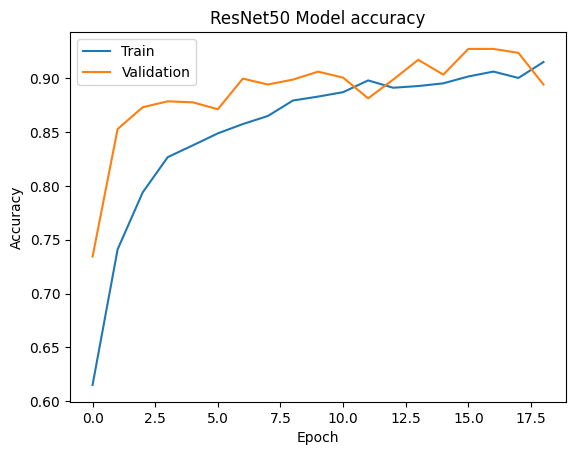

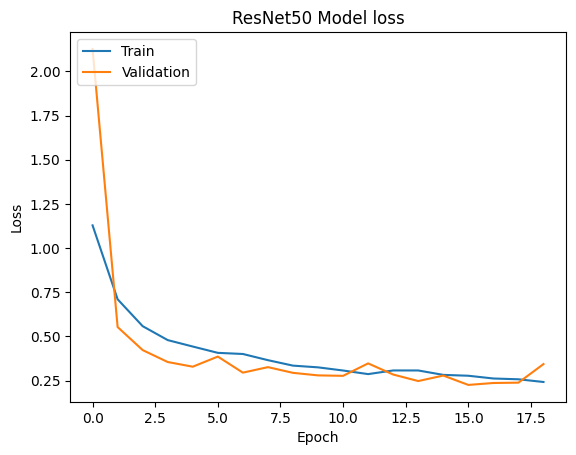

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [8]:
#if __name__ == "__main__":
main()

In [9]:
import tensorflow

In [10]:
tensorflow.__version__

'2.13.0'

In [11]:
import numpy as np
np.__version__

'1.24.3'

In [12]:
import matplotlib
matplotlib.__version__

'3.7.4'